# Neural Networks

> A simple neural network to regress a quadratic function

In [65]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange
from torch.distributions.uniform import Uniform

torch.manual_seed(19)
np.random.seed(19)

In this tutorial, we are investigating how a simple neural network approximates a simple non-linear function.
In this case, we will try to approximate the quadratic function $y = f(x) = x^2$:

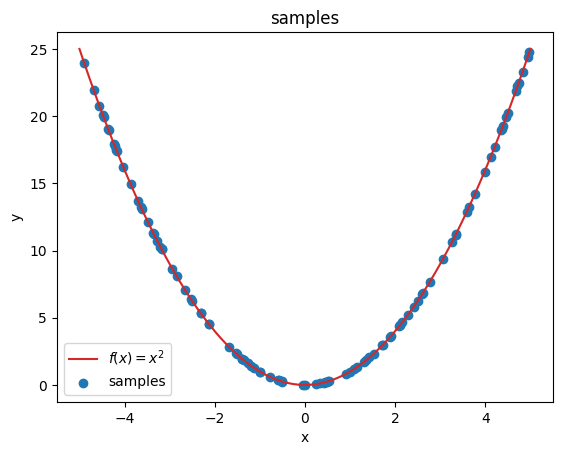

In [66]:
# ground truth function f(x) = x^2 that we want to approximate
x_plot = np.linspace(-5, 5, 100)
y_plot = x_plot * x_plot

# draw training samples
x = np.random.uniform(-5, 5, 100)
y = x * x

def plot_samples(x, y, title = "samples"):
    global x_plot, y_plot
    plt.plot(x_plot, y_plot, color="tab:red", label="$f(x)=x^2$")
    plt.scatter(x, y, label="samples")
    plt.gca().set(xlabel="x", ylabel="y")
    plt.legend()
    plt.title(title)

plot_samples(x, y)

We will use PyTorch to build our neural network 

In [67]:
from torch.optim import SGD

# number of hidden units
N_HIDDEN = 8

# define the layout of our neural network
model = nn.Sequential(
    nn.Linear(1, N_HIDDEN),
    # we will use ReLU as our non-linear activation function
    nn.ReLU(),
    nn.Linear(N_HIDDEN, 1)
)

# you can ignore this for now
# later, this hook will save as the latent representations
activations = dict()
def hook(module, x_in, x_out):
    global activations
    activations["latent"] = x_out.detach()
model[1].register_forward_hook(hook)

# the optimizer will update the model parameters for us
# we will use SGD: Stochastic Gradient Descent
LEARNING_RATE = 0.02
optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

# number of iterations that we will train our model
EPOCHS = 5000

# our loss function: defines error between predictions and targets
# we will use Mean Squared Error, since it is a regression task
criterion = nn.MSELoss()

# for torch, we need to do some reshaping of our training data
# our network expects a single number as input
# so we need to reshape x/y from (100,) to (100,1), including a batch dimension
x_train = torch.from_numpy(x).reshape(-1, 1).float()
y_train = torch.from_numpy(y).reshape(-1, 1).float()

loss_log = []

for i in trange(EPOCHS):
    # 1. forward pass: get model predictions
    y_hat = model(x_train)
    # 2. compute loss: error between predictions and targets
    loss = criterion(y_hat, y_train)
    # 3. backward pass: propagate gradient trough network
    loss.backward()
    loss_log.append(loss.item())
    # 4. update parameters: perform one optimization step
    optimizer.step()
    # 5. reset torch gradients
    optimizer.zero_grad()

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 0, 'epoch')

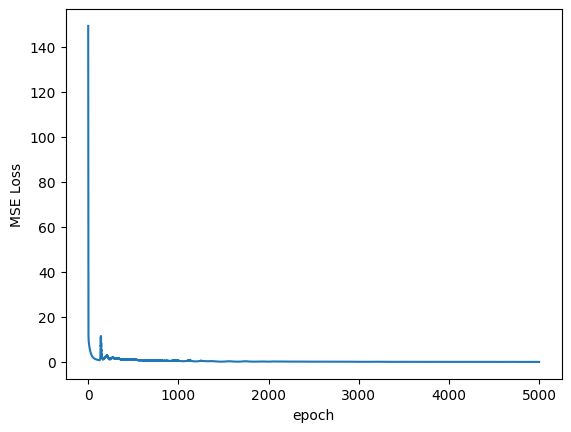

In [68]:
# plot the loss curve
plt.plot(loss_log)
plt.ylabel("MSE Loss")
plt.xlabel("epoch")

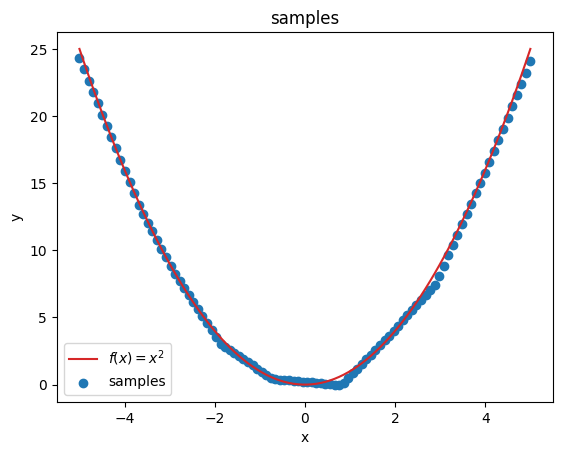

In [69]:
# don't need gradients to predict on whole linspace
with torch.no_grad():
    x_test = torch.from_numpy(x_plot).reshape(-1, 1).float()
    y_pred = model(x_test).reshape(-1).detach().numpy()

# plot predictions
plot_samples(x_plot, y_pred);

But what's going on within the model?
Let's investigate by visualizing the latent activations.
This gives us a clue, what each neuron learned:

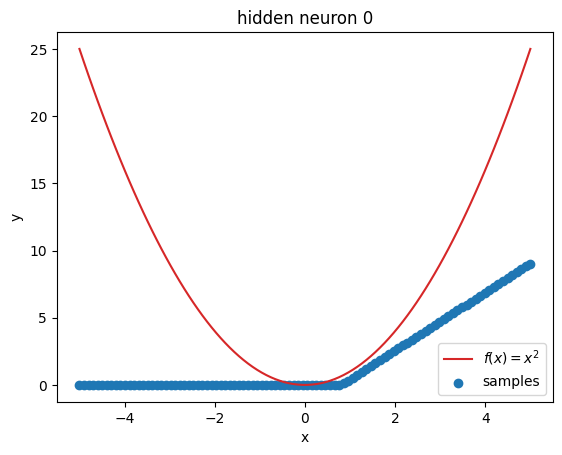

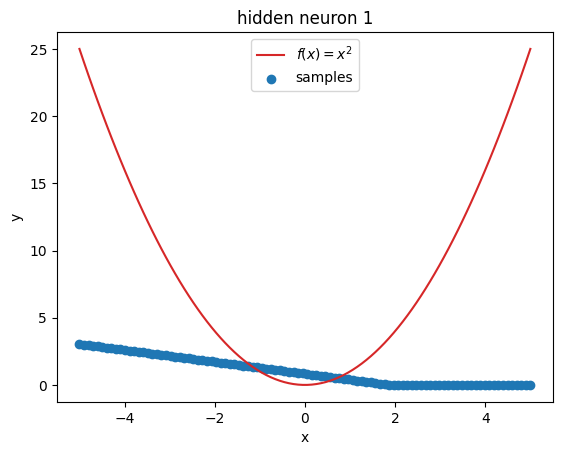

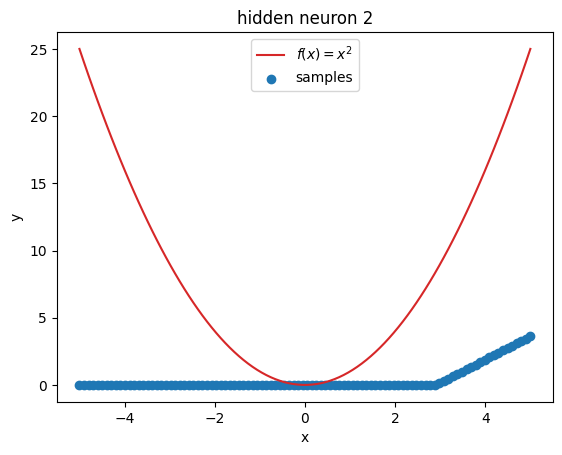

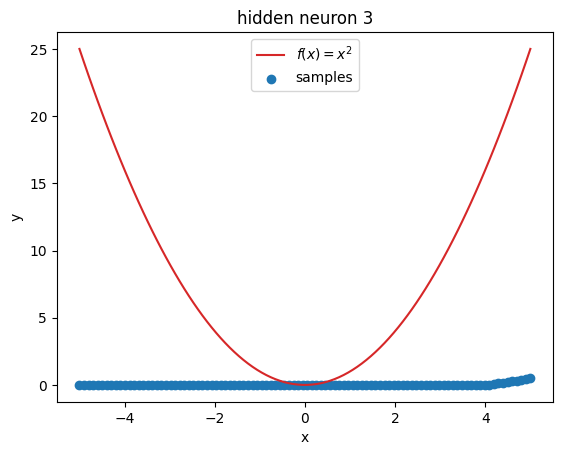

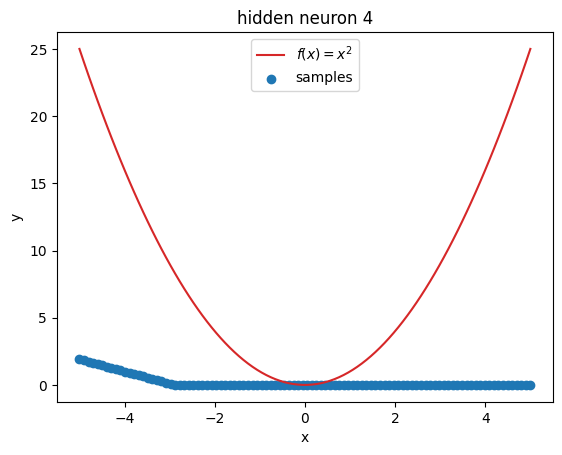

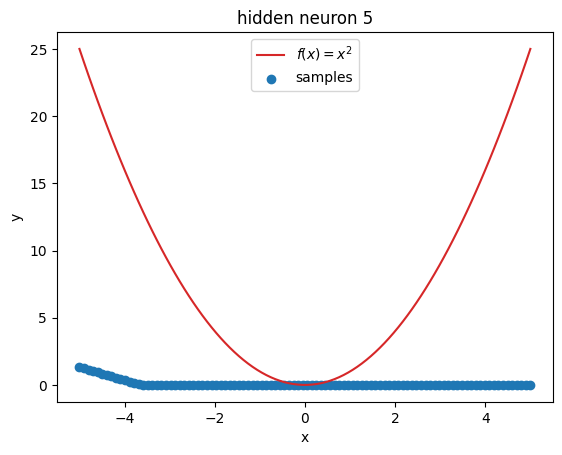

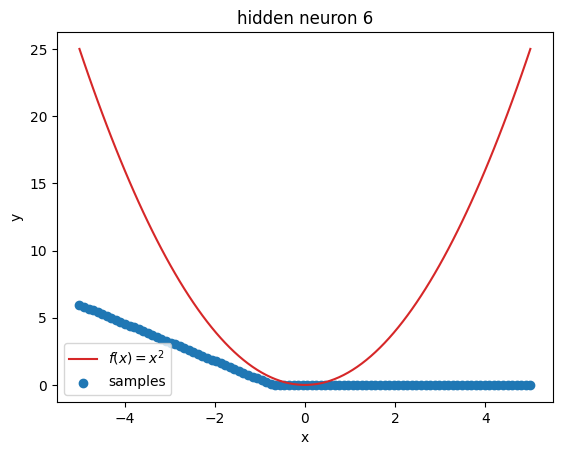

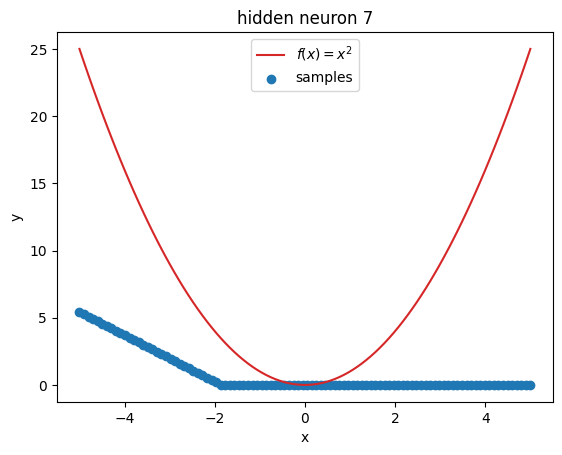

In [71]:
z = activations["latent"]

for i in range(z.shape[1]):
    plt.figure()
    plot_samples(x_plot, z[:, i].detach().numpy(), f"hidden neuron {i}")

## Tasks

1. Try out different values for `LEARNING_RATE` and `EPOCHS`. How does the loss change?
2. Try different numbers of hidden units by changing `N_HIDDEN`. How does the quality of the approximation change?